In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import mne
import numpy as np
# from copy import deepcopy
# import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import create_forward_model, get_info
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
plot_params = dict(surface='white', hemi='both', verbose=0)

## Create Forward model
First we create a template forward model which comes with the esinet package

In [2]:
info = get_info(sfreq=100, kind="biosemi64")
fwd = create_forward_model(sampling="ico3", info=info)
_, pos = util.unpack_fwd(fwd)[1:3]
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

import mne
from scipy.sparse.csgraph import laplacian

adjacency = mne.spatial_src_adjacency(fwd['src']).toarray()
laplace_operator = abs(laplacian(adjacency))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.0s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.4s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


-- number of adjacent vertices : 1284


# Defs

In [78]:
import tensorflow as tf
def prep_data(X, y):
    X = np.stack([(x - np.mean(x)) / np.std(x) for x in X], axis=0)
    y = np.stack([(x / np.max(abs(x))) for x in y], axis=0)
    return X, y

def data_loss(x, y, ord=2):
    return np.linalg.norm(x-y, ord=ord)

def l1_norm(x):
    return np.linalg.norm(x, ord=1)
    
def temporal_reg(x):
    return np.std(abs(x), axis=1)

def compute_cosine_distances(a, b):
    # x shape is n_a * dim
    # y shape is n_b * dim
    # results shape is n_a * n_b

    normalize_a = tf.nn.l2_normalize(a,-1)        
    normalize_b = tf.nn.l2_normalize(b,-1)
    distance = 1 - tf.matmul(normalize_a, normalize_b, transpose_b=True)
    return distance

# Simulate

In [108]:
settings = dict(duration_of_trial=0.25, extents=(1,40), number_of_sources=(1,15), target_snr=1e99)
sim = Simulation(fwd, info, settings=settings).simulate(n_samples=100)
y = np.stack([eeg.average().data for eeg in sim.eeg_data], axis=0)
x = np.stack([source.data for source in sim.source_data], axis=0)
# x = x[0, :, 0]
# y = y[0, :, 0]
sim.source_data[0].plot(**plot_params)

Simulating data based on sparse patches.


100%|██████████| 100/100 [00:01<00:00, 72.89it/s]


# Solve

## Create

In [100]:
from scipy.optimize import minimize

print(x.shape, y.shape)
constr = dict(type="eq", fun=lambda x: np.linalg.norm(leadfield @ x - y))
options = dict(maxiter=100)
tol = 1e-6
x0 = np.zeros(x.shape) #np.linalg.pinv(leadfield) @ y
res = minimize(l1_norm, x0, method="SLSQP", constraints=constr, options=options, tol=tol)
src_hat = res["x"]

(1284,) (64,)


KeyboardInterrupt: 

In [129]:
y, x = prep_data(y,x)
model = tf.keras.experimental.LinearModel(units=x.shape[1])
model.compile(optimizer="adam", loss="mae")
model.fit(y[:,:,0], x[:,:,0], epochs=200)

Epoch 1/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 2/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 3/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 4/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0166
Epoch 5/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0156
Epoch 6/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 7/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 8/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0137
Epoch 9/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0129
Epoch 10/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 11/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 12/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 13/200
4/4 [==============================] - 0s 2ms/st

No projector specified for this dataset. Please consider the method self.add_proj.


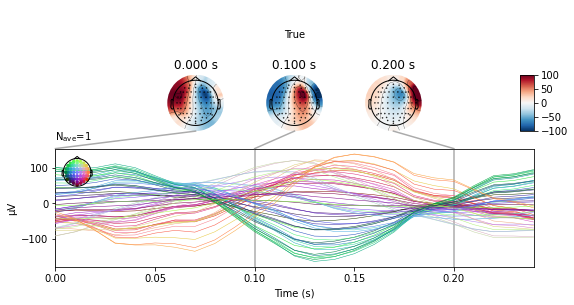

No projector specified for this dataset. Please consider the method self.add_proj.


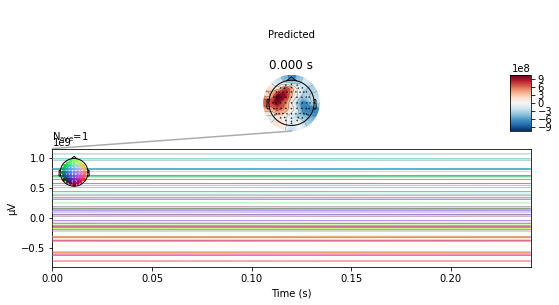

AUC:  0.5079426125342472  Corrs:  0.0019979200319767375  nMSE:  0.11575045848090407


Text(0.5, 1.0, '0.00')

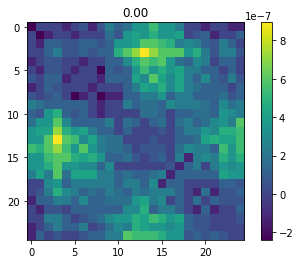

Using control points [0.57133426 0.70046579 0.70046579]
Using control points [0.61538156 0.69291438 0.95648596]


Traceback (most recent call last):
  File "c:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\utils.py", line 60, in safe_event
    return fun(*args, **kwargs)
  File "c:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 731, in _clean
    self.clear_glyphs()
  File "c:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1629, in clear_glyphs
    assert sum(len(v) for v in self.picked_points.values()) == 0
AssertionError


In [135]:
from esinet.evaluate import eval_auc
from scipy.stats import pearsonr
idx = 0
stc = sim.source_data[idx].copy()
stc.data /= np.max(abs(stc.data))

stc.plot(**plot_params)
evoked = sim.eeg_data[idx].average()
evoked.plot_joint(title="True", times=[0, 0.10, 0.20])
stc_hat = stc.copy()
src_hat  = model.predict(evoked.data.T).T
stc_hat.data = src_hat
stc_hat.data /= np.max(abs(stc_hat.data))
stc_hat.plot(**plot_params, brain_kwargs=dict(title="Prediction"))

evoked_ = util.get_eeg_from_source(stc_hat, fwd, info, tmin=evoked.tmin)
evoked_.plot_joint(title=f"Predicted", times=[0,])


auc = np.mean([np.mean(eval_auc(y_true_sample, y_pred_sample, pos)) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
corrs = np.mean([np.mean(pearsonr(y_true_sample, y_pred_sample)[0]) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
nmses = np.mean([np.mean((y_true_sample - y_pred_sample)**2) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])

print("AUC: ", auc, " Corrs: ", corrs, " nMSE: ", nmses)
mat = compute_cosine_distances(abs(stc_hat.data.T), abs(stc_hat.data.T)).numpy()
plt.figure()
plt.imshow(mat)
plt.colorbar()
plt.title(f"{mat.mean():.2f}")

## Evaluate

No projector specified for this dataset. Please consider the method self.add_proj.


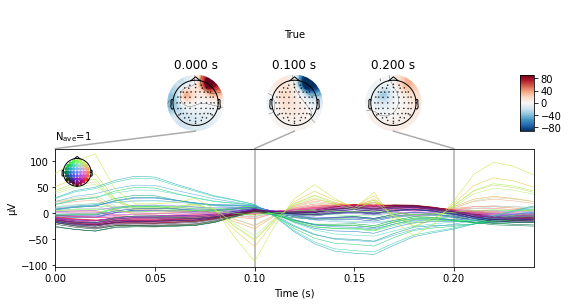

No projector specified for this dataset. Please consider the method self.add_proj.


c:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\evoked.py:521: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


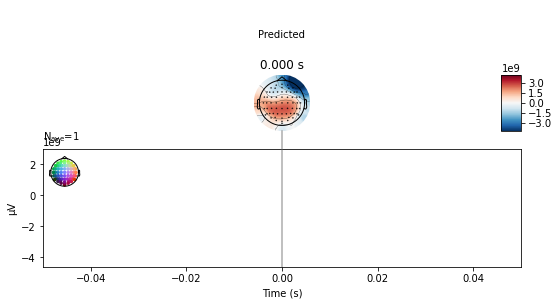

AUC:  0.6771279916753381  Corrs:  -0.18907639647591093  nMSE:  0.1406457197346891


Text(0.5, 1.0, '-0.00')

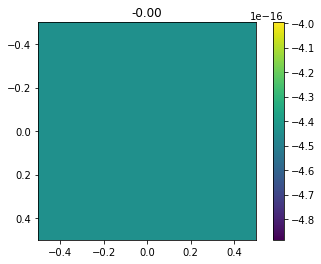

In [98]:
from esinet.evaluate import eval_auc
from scipy.stats import pearsonr
idx = 0
stc = sim.source_data[idx].copy()
stc.data /= np.max(abs(stc.data))

stc.plot(**plot_params)
evoked = sim.eeg_data[idx].average()
evoked.plot_joint(title="True", times=[0, 0.10, 0.20])
stc_hat = stc.copy()
stc_hat.data = src_hat[:, np.newaxis]
stc_hat.data /= np.max(abs(stc_hat.data))
stc_hat.plot(**plot_params, brain_kwargs=dict(title="Prediction"))

evoked_ = util.get_eeg_from_source(stc_hat, fwd, info, tmin=evoked.tmin)
evoked_.plot_joint(title=f"Predicted", times=[0,])


auc = np.mean([np.mean(eval_auc(y_true_sample, y_pred_sample, pos)) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
corrs = np.mean([np.mean(pearsonr(y_true_sample, y_pred_sample)[0]) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
nmses = np.mean([np.mean((y_true_sample - y_pred_sample)**2) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])

print("AUC: ", auc, " Corrs: ", corrs, " nMSE: ", nmses)
mat = compute_cosine_distances(abs(stc_hat.data.T), abs(stc_hat.data.T)).numpy()
plt.figure()
plt.imshow(mat)
plt.colorbar()
plt.title(f"{mat.mean():.2f}")

In [ ]:
plt.figure()
plt.imshow(compute_cosine_distances(abs(stc_hat.data.T), abs(stc_hat.data.T)).numpy())
plt.colorbar()

plt.figure()
plt.imshow(compute_cosine_distances(abs(stc.data.T), abs(stc.data.T)).numpy())
plt.colorbar()

In [ ]:
plt.figure()
plt.hist(compute_cosine_distances(abs(stc_hat.data.T), abs(stc_hat.data.T)).numpy().flatten())

plt.figure()
plt.hist(compute_cosine_distances(abs(stc.data.T), abs(stc.data.T)).numpy().flatten())

In [ ]:
sys.path.insert(0, '../../invert/')
from invert.solvers.minimum_norm_estimates import SolverDynamicStatisticalParametricMapping, SolverMinimumNorm
from invert.solvers.wrop import SolverLAURA
from invert.solvers.empirical_bayes import SolverChampagne

# solver = SolverLAURA().make_inverse_operator(fwd)
solver = SolverChampagne().make_inverse_operator(fwd)
# solver = SolverMinimumNorm().make_inverse_operator(fwd)

stc_mne = solver.apply_inverse_operator(sim_test.eeg_data[0].average())
stc_mne.data = stc_mne.data / np.max(abs(stc_mne.data))
stc_mne.plot(**plot_params, brain_kwargs=dict(title=solver.name))
auc = np.mean([np.mean(eval_auc(y_true_sample, y_pred_sample, pos)) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_mne.data.T)])
corrs = np.mean([np.mean(pearsonr(y_true_sample, y_pred_sample)[0]) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_mne.data.T)])
nmses = np.mean([np.mean((y_true_sample - y_pred_sample)**2) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_mne.data.T)])

print(model.name, " AUC: ", auc, " Corrs: ", corrs, " nMSE: ", nmses, "\n")